In [25]:
#LOAD AND SPLIT DATA
# mnist basic setting: https://github.com/pytorch/examples/blob/master/mnist/main.py
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

# Training Settings
batch_size = 64

valid_size = 0.2 #Validation set size, eg 0.1 is %10
random_seed = 5 #Rand seed for reproduction


train_dataset = datasets.MNIST(root='./data/',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='./data/',
                              train=False,
                              transform=transforms.ToTensor())


#Validation Set Split
#ref https://gist.github.com/kevinzakka/d33bf8d6c7f06a9d8c76d97a7879f5cb
num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))

#rand shuffle:
np.random.seed(random_seed)
np.random.shuffle(indices)

#Define samplers for train val sets
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


# Train/Val/Test Data Loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           sampler = train_sampler)

valid_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           sampler = valid_sampler)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

print("Train Set Size: " + str(len(train_loader.dataset)) + "   Validation Ratio: %"  + str(valid_size*100) + "   Test Set Size: " +str(len(test_loader.dataset)) )    

Train Set Size: 60000   Validation Ratio: %20.0   Test Set Size: 10000


In [35]:

noiseBranchCount = 1000     #Branch count for noisy network

test_run = 0            #Train/Test time 

startFilterCount = 8     #Network width

scale = 0.0001
    
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        #INITIAL [5x5 MP]
        self.conv1 = nn.Conv2d(1, startFilterCount, kernel_size=5)
        
        # Block1 [3x3 3x3 MP]
        self.conv2 = nn.Conv2d(startFilterCount, startFilterCount*2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(startFilterCount*2, startFilterCount*2, kernel_size=3, padding=1)
        
        # Block2 [3x3 3x3 MP]
        self.conv4 = nn.Conv2d(startFilterCount*2, startFilterCount*4, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(startFilterCount*4, startFilterCount*4, kernel_size=3, padding=1)
        
        self.gauss = nn.Conv2d(startFilterCount*4, startFilterCount*4, kernel_size=3, padding=1)
        
        self.mp = nn.MaxPool2d(2)
        self.fc = nn.Linear(288, 10)
        
        #Initalize random generator
        #Generator gives error, investigate later
        #self.gen = torch.Generator()
        #torch.manualSeed(gen, 5)
        

    def forward(self, x):
        in_size = x.size(0)
        #Initial conv mp
        x = F.relu(self.mp(self.conv1(x)))
        #Block1 - conv relu conv relu mp
        x = F.relu(self.conv2(x))
        x = F.relu(self.mp(self.conv3(x)))
        #Block2 - conv relu conv relu mp
        x = F.relu(self.conv4(x))
        x = self.conv5(x)
        
        #last_weights = self.conv5.weights
        #print(last_weights)
        
        #TEST ROUTINE
        if not self.training:
            
            #32 32 ----> number of filters -- 3x3 kernel size 
            #w = self.conv5.parameters()
            #b = self.conv5.bias
            
            #display(w)
            #w2 = list(w)
            #display(we.data.cpu().numpy().size)
            #print(we.data.size())
            
            #Weights are extracted from conv5
            we = self.conv5
            
            #Kernel Sampling
            #normal_(mean=0, std=1, *, generator=None)
            #self.gauss.weight.data.normal_(mean=0, std=1)
            #self.gauss.bias.data.normal_(mean=0, std=1)
            #we.weight.data:add(self.gauss.weight.data)
            #we.bias.data:add(self.gauss.bias.data)
            
            #OTF Sampling
            #Weight
            sc = torch.FloatTensor([scale])
            rand_w = torch.rand(32, 32, 3, 3)
            rand_w = torch.mul(rand_w,sc)
            we.weight.data:add(rand_w.data)
            #Bias
            rand_b = torch.rand(32)
            rand_w = torch.mul(rand_b,sc)
            we.bias.data:add(rand_b.data)
            
            #
            
            #b = torch.from_numpy(a)
            #addNoise(we.data)
            
            #Merge classifier results
            x = F.relu(self.mp(x))        
            x = x.view(in_size, -1)  # flatten the tensor
            x = self.fc(x)
            x =  F.log_softmax(x)
            
            
            
        else:    
            
            x = F.relu(self.mp(x))
        
            #FC
            x = x.view(in_size, -1)  # flatten the tensor
            #print(x.size(1))    # FC feature size 
            x = self.fc(x)
        
            x =  F.log_softmax(x)
        return x
    def addNoise(self,c_weights):
        mu, sigma = 0, 0.1 # mean and standard deviation
        s = np.random.normal(mu, sigma, 1000)


model = Net()
model = model.cuda()
#torch.save(net.module.cpu().state_dict(), save_path)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
        

In [36]:
test_run = 1
test()

/home/john/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Average loss: 2.3030, Accuracy: 958/10000 (9.58%)



In [37]:
train_list = []
val_list = []
test_list = [] 
test_accur_list = []
epoch_list = []
final_test_loss = 0

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        #GPU
        data = data.cuda()
        target = target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        #if batch_idx % 10 == 0:
        #    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #        epoch, batch_idx * len(data), len(train_loader.dataset),
        #        100. * batch_idx / len(train_loader), loss.data[0]))
        if batch_idx == len(train_loader) - 1:
            train_list.append(loss.data[0])
            
def validate():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in valid_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        #GPU
        data = data.cuda()
        target = target.cuda()
        output = model(data)
        # sum up batch loss
        test_loss += F.nll_loss(output, target, size_average=False).data[0]
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(valid_idx)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(valid_idx),
        100. * correct / len(valid_idx)))
    val_list.append(test_loss)

def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        #GPU
        data = data.cuda()
        target = target.cuda()
        output = model(data)
        # sum up batch loss
        test_loss += F.nll_loss(output, target, size_average=False).data[0]
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_list.append(test_loss)
    test_accur = 100. * correct / len(test_loader.dataset)
    test_accur_list.append(test_accur)
    final_test_loss = test_loss


totalEpoch = 3
    
for epoch in range(1, totalEpoch+1):
    train(epoch)
    print("Epoch: " + str(epoch))
    validate()
    #test()


/home/john/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:105: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1


/home/john/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Validation set: Average loss: 2.2706, Accuracy: 3599/12000 (29.99%)

Epoch: 2

Validation set: Average loss: 0.2083, Accuracy: 11243/12000 (93.69%)

Epoch: 3

Validation set: Average loss: 0.1528, Accuracy: 11425/12000 (95.21%)



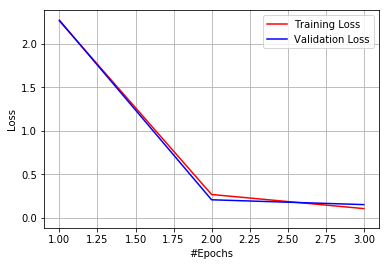

In [38]:
%matplotlib inline
#Plot train/test stuff 
epoch_list = list(range(1,totalEpoch+1))

#Plotting
import matplotlib.pyplot as plt
import numpy as np    
import matplotlib.lines as mlines

plt.plot(epoch_list,train_list, 'r', epoch_list, val_list, 'b', totalEpoch, final_test_loss, 'r--')
plt.ylabel('Loss')
plt.xlabel('#Epochs')
plt.grid(True)

#Legends
blue_line = mlines.Line2D([], [], color='blue',
                          markersize=15, label='Validation Loss')
red_line = mlines.Line2D([], [], color='red',
                          markersize=15, label='Training Loss')
plt.legend(handles=[red_line, blue_line])

plt.show()    

In [ ]:
#Get test results at min validation loss

#Find index of min from list 
#ref https://stackoverflow.com/questions/13300962/python-find-index-of-minimum-item-in-list-of-floats
minVal, minKey = min((minVal, minKey) for (minKey, minVal) in enumerate(val_list))

print("Minimum Validation Loss is on Epoch: " + str(minKey+1) + " ( %" +str(minVal) +" )" )
print("Test Accuracy on Epoch " + str(minKey+1) + ":  %" + str(test_accur_list[minKey]))
#Test loss test_list(minKey) 


In [21]:
#Test the model
test()

/home/john/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Average loss: 0.1126, Accuracy: 9658/10000 (96.58%)

